# Build a Customer Support Bot

Customer support bots can free up teams' time by handling routine issues, but it can be hard to build a bot that reliably handles diverse tasks in a way that doesn't leave the user pulling their hair out.

In this tutorial, you will build a customer support bot for an airline to help users research and make travel arrangements. You'll learn to use LangGraph's interrupts and checkpointers and more complex state to organize your assistant's tools and manage a user's flight bookings, hotel reservations, car rentals, and excursions. It assumes you are familiar with the concepts presented in the [LangGraph introductory tutorial](https://langchain-ai.github.io/langgraph/tutorials/introduction/).

By the end, you'll have built a working bot and gained an understanding of  LangGraph's key concepts and architectures. You'll be able to apply these design patterns to your other AI projects.

Your final chat bot will look something like the following diagram:
![](https://raw.githubusercontent.com/greedisneutral/NLP-course/refs/heads/2025/13.Agents/homework/img/customer-support-bot-4.png)

Let's start!

## Prerequisites

First, set up your environment. We'll install this tutorial's prerequisites, download the test DB, and define the tools we will reuse in each section.

We'll be using Claude as our LLM and define a number of custom tools. While most of our tools will connect to a local sqlite database (and require no additional dependencies), we will also provide a general web search to the agent using [Tavily](https://www.tavily.com/).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture --no-stderr
%pip install -U langgraph langchain-community langchain_openai tavily-python pandas openai

In [3]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# 1. Request your OpenRouter Key
_set_env("OPENROUTER_API_KEY")

# 2. Configure the environment to route OpenAI calls to OpenRouter
# This "tricks" LangChain into sending requests to OpenRouter instead of OpenAI
os.environ["OPENAI_API_KEY"] = os.environ["OPENROUTER_API_KEY"]
os.environ["OPENAI_BASE_URL"] = "https://openrouter.ai/api/v1"

# 3. Keep Tavily for search tools (Sign up for a free tier key at tavily.com)
# If you cannot use Tavily, you will need to remove the search tools later in the tutorial
_set_env("TAVILY_API_KEY")


OPENROUTER_API_KEY: ··········
TAVILY_API_KEY: ··········


<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>.
    </p>
</div>

In [5]:
import os

# 1. Use the "Classic" names that the Python library definitely supports
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"

# 2. Paste your specific API Key
_set_env("LANGCHAIN_API_KEY")

# 3. Use your Project Name
os.environ["LANGCHAIN_PROJECT"] = "pr-ample-stump-82"


LANGCHAIN_API_KEY: ··········


#### Populate the database

Run the next script to fetch a `sqlite` DB we've prepared for this tutorial and update it to look like it's current. The details are unimportant.

In [6]:
import os
import shutil
import sqlite3

import pandas as pd
import requests

db_url = "https://storage.googleapis.com/benchmarks-artifacts/travel-db/travel2.sqlite"
local_file = "travel2.sqlite"
# The backup lets us restart for each tutorial section
backup_file = "travel2.backup.sqlite"
overwrite = False
if overwrite or not os.path.exists(local_file):
    response = requests.get(db_url)
    response.raise_for_status()  # Ensure the request was successful
    with open(local_file, "wb") as f:
        f.write(response.content)
    # Backup - we will use this to "reset" our DB in each section
    shutil.copy(local_file, backup_file)


# Convert the flights to present time for our tutorial
def update_dates(file):
    shutil.copy(backup_file, file)
    conn = sqlite3.connect(file)
    cursor = conn.cursor()

    tables = pd.read_sql(
        "SELECT name FROM sqlite_master WHERE type='table';", conn
    ).name.tolist()
    tdf = {}
    for t in tables:
        tdf[t] = pd.read_sql(f"SELECT * from {t}", conn)

    example_time = pd.to_datetime(
        tdf["flights"]["actual_departure"].replace("\\N", pd.NaT)
    ).max()
    current_time = pd.to_datetime("now").tz_localize(example_time.tz)
    time_diff = current_time - example_time

    tdf["bookings"]["book_date"] = (
        pd.to_datetime(tdf["bookings"]["book_date"].replace("\\N", pd.NaT), utc=True)
        + time_diff
    )

    datetime_columns = [
        "scheduled_departure",
        "scheduled_arrival",
        "actual_departure",
        "actual_arrival",
    ]
    for column in datetime_columns:
        tdf["flights"][column] = (
            pd.to_datetime(tdf["flights"][column].replace("\\N", pd.NaT)) + time_diff
        )

    for table_name, df in tdf.items():
        df.to_sql(table_name, conn, if_exists="replace", index=False)
    del df
    del tdf
    conn.commit()
    conn.close()

    return file


db = update_dates(local_file)

## Tools

Next, define our assistant's tools to search the airline's policy manual and search and manage reservations for flights, hotels, car rentals, and excursions. We will reuse these tools throughout the tutorial. The exact implementations
aren't important, so feel free to run the code below and jump to [Part 1](#part-1-zero-shot).

#### Lookup Company Policies

The assistant retrieve policy information to answer user questions. Note that _enforcement_ of these policies still must be done within the tools/APIs themselves, since the LLM can always ignore this.

In [7]:
import re

import openai
from langchain_core.tools import tool

response = requests.get(
    "https://storage.googleapis.com/benchmarks-artifacts/travel-db/swiss_faq.md"
)
response.raise_for_status()
faq_text = response.text

docs = [{"page_content": txt} for txt in re.split(r"(?=\n##)", faq_text)]


You have two options for generating embeddings. Choose ONE by uncommenting the corresponding class definition.

OPTION 1: OpenAI API (requires API key and may need credit purchase). If it works for you, feel free to skip an alternative.

In [8]:
import numpy as np

In [9]:
class VectorStoreRetriever:
    def __init__(self, docs: list, vectors: list, oai_client):
        self._arr = np.array(vectors)
        self._docs = docs
        self._client = oai_client

    @classmethod
    def from_docs(cls, docs, oai_client):
        embeddings = oai_client.embeddings.create(
            model="text-embedding-3-small", input=[doc["page_content"] for doc in docs]
        )
        vectors = [emb.embedding for emb in embeddings.data]
        return cls(docs, vectors, oai_client)

    def query(self, query: str, k: int = 5) -> list[dict]:
        embed = self._client.embeddings.create(
            model="text-embedding-3-small", input=[query]
        )
        # "@" is just a matrix multiplication in python
        scores = np.array(embed.data[0].embedding) @ self._arr.T
        top_k_idx = np.argpartition(scores, -k)[-k:]
        top_k_idx_sorted = top_k_idx[np.argsort(-scores[top_k_idx])]
        return [
            {**self._docs[idx], "similarity": scores[idx]} for idx in top_k_idx_sorted
        ]


In [10]:
retriever = VectorStoreRetriever.from_docs(docs, openai.Client())


@tool
def lookup_policy(query: str) -> str:
    """Consult the company policies to check whether certain options are permitted.
    Use this before making any flight changes performing other 'write' events."""
    docs = retriever.query(query, k=2)
    return "\n\n".join([doc["page_content"] for doc in docs])

#### Flights

Define the (`fetch_user_flight_information`) tool to let the agent see the current user's flight information.  Then define tools to search for flights and manage the passenger's bookings stored in the SQL database.

We then can [access the RunnableConfig](https://python.langchain.com/docs/how_to/tool_configure/#inferring-by-parameter-type) for a given run to check the `passenger_id` of the user accessing this application. The LLM never has to provide these explicitly, they are provided for a given invocation of the graph so that each user cannot access other passengers' booking information.

<div class="admonition warning">
    <p class="admonition-title">Compatibility</p>
    <p>
        This tutorial expects `langchain-core>=0.2.16` to use the injected RunnableConfig. Prior to that, you'd use `ensure_config` to collect the config from context.
    </p>
</div>


In [11]:
import sqlite3
from datetime import date, datetime
from typing import Optional

import pytz
from langchain_core.runnables import RunnableConfig


@tool
def fetch_user_flight_information(config: RunnableConfig) -> list[dict]:
    """Fetch all tickets for the user along with corresponding flight information and seat assignments.

    Returns:
        A list of dictionaries where each dictionary contains the ticket details,
        associated flight details, and the seat assignments for each ticket belonging to the user.
    """
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = """
    SELECT
        t.ticket_no, t.book_ref,
        f.flight_id, f.flight_no, f.departure_airport, f.arrival_airport, f.scheduled_departure, f.scheduled_arrival,
        bp.seat_no, tf.fare_conditions
    FROM
        tickets t
        JOIN ticket_flights tf ON t.ticket_no = tf.ticket_no
        JOIN flights f ON tf.flight_id = f.flight_id
        JOIN boarding_passes bp ON bp.ticket_no = t.ticket_no AND bp.flight_id = f.flight_id
    WHERE
        t.passenger_id = ?
    """
    cursor.execute(query, (passenger_id,))
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results


@tool
def search_flights(
    departure_airport: Optional[str] = None,
    arrival_airport: Optional[str] = None,
    start_time: Optional[date | datetime] = None,
    end_time: Optional[date | datetime] = None,
    limit: int = 20,
) -> list[dict]:
    """Search for flights based on departure airport, arrival airport, and departure time range."""
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM flights WHERE 1 = 1"
    params = []

    if departure_airport:
        query += " AND departure_airport = ?"
        params.append(departure_airport)

    if arrival_airport:
        query += " AND arrival_airport = ?"
        params.append(arrival_airport)

    if start_time:
        query += " AND scheduled_departure >= ?"
        params.append(start_time)

    if end_time:
        query += " AND scheduled_departure <= ?"
        params.append(end_time)
    query += " LIMIT ?"
    params.append(limit)
    cursor.execute(query, params)
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results


@tool
def update_ticket_to_new_flight(
    ticket_no: str, new_flight_id: int, *, config: RunnableConfig
) -> str:
    """Update the user's ticket to a new valid flight."""
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "SELECT departure_airport, arrival_airport, scheduled_departure FROM flights WHERE flight_id = ?",
        (new_flight_id,),
    )
    new_flight = cursor.fetchone()
    if not new_flight:
        cursor.close()
        conn.close()
        return "Invalid new flight ID provided."
    column_names = [column[0] for column in cursor.description]
    new_flight_dict = dict(zip(column_names, new_flight))
    timezone = pytz.timezone("Etc/GMT-3")
    current_time = datetime.now(tz=timezone)
    departure_time = datetime.strptime(
        new_flight_dict["scheduled_departure"], "%Y-%m-%d %H:%M:%S.%f%z"
    )
    time_until = (departure_time - current_time).total_seconds()
    if time_until < (3 * 3600):
        return f"Not permitted to reschedule to a flight that is less than 3 hours from the current time. Selected flight is at {departure_time}."

    cursor.execute(
        "SELECT flight_id FROM ticket_flights WHERE ticket_no = ?", (ticket_no,)
    )
    current_flight = cursor.fetchone()
    if not current_flight:
        cursor.close()
        conn.close()
        return "No existing ticket found for the given ticket number."

    # Check the signed-in user actually has this ticket
    cursor.execute(
        "SELECT * FROM tickets WHERE ticket_no = ? AND passenger_id = ?",
        (ticket_no, passenger_id),
    )
    current_ticket = cursor.fetchone()
    if not current_ticket:
        cursor.close()
        conn.close()
        return f"Current signed-in passenger with ID {passenger_id} not the owner of ticket {ticket_no}"

    # In a real application, you'd likely add additional checks here to enforce business logic,
    # like "does the new departure airport match the current ticket", etc.
    # While it's best to try to be *proactive* in 'type-hinting' policies to the LLM
    # it's inevitably going to get things wrong, so you **also** need to ensure your
    # API enforces valid behavior
    cursor.execute(
        "UPDATE ticket_flights SET flight_id = ? WHERE ticket_no = ?",
        (new_flight_id, ticket_no),
    )
    conn.commit()

    cursor.close()
    conn.close()
    return "Ticket successfully updated to new flight."


@tool
def cancel_ticket(ticket_no: str, *, config: RunnableConfig) -> str:
    """Cancel the user's ticket and remove it from the database."""
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "SELECT flight_id FROM ticket_flights WHERE ticket_no = ?", (ticket_no,)
    )
    existing_ticket = cursor.fetchone()
    if not existing_ticket:
        cursor.close()
        conn.close()
        return "No existing ticket found for the given ticket number."

    # Check the signed-in user actually has this ticket
    cursor.execute(
        "SELECT ticket_no FROM tickets WHERE ticket_no = ? AND passenger_id = ?",
        (ticket_no, passenger_id),
    )
    current_ticket = cursor.fetchone()
    if not current_ticket:
        cursor.close()
        conn.close()
        return f"Current signed-in passenger with ID {passenger_id} not the owner of ticket {ticket_no}"

    cursor.execute("DELETE FROM ticket_flights WHERE ticket_no = ?", (ticket_no,))
    conn.commit()

    cursor.close()
    conn.close()
    return "Ticket successfully cancelled."

#### Car Rental Tools

Once a user books a flight, they likely will want to organize transportation. Define some "car rental" tools to let the user search for and reserve a car at their destination.

In [12]:
from datetime import date, datetime
from typing import Optional, Union


@tool
def search_car_rentals(
    location: Optional[str] = None,
    name: Optional[str] = None,
    price_tier: Optional[str] = None,
    start_date: Optional[Union[datetime, date]] = None,
    end_date: Optional[Union[datetime, date]] = None,
) -> list[dict]:
    """
    Search for car rentals based on location, name, price tier, start date, and end date.

    Args:
        location (Optional[str]): The location of the car rental. Defaults to None.
        name (Optional[str]): The name of the car rental company. Defaults to None.
        price_tier (Optional[str]): The price tier of the car rental. Defaults to None.
        start_date (Optional[Union[datetime, date]]): The start date of the car rental. Defaults to None.
        end_date (Optional[Union[datetime, date]]): The end date of the car rental. Defaults to None.

    Returns:
        list[dict]: A list of car rental dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM car_rentals WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    # For our tutorial, we will let you match on any dates and price tier.
    # (since our toy dataset doesn't have much data)
    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


@tool
def book_car_rental(rental_id: int) -> str:
    """
    Book a car rental by its ID.

    Args:
        rental_id (int): The ID of the car rental to book.

    Returns:
        str: A message indicating whether the car rental was successfully booked or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE car_rentals SET booked = 1 WHERE id = ?", (rental_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully booked."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."


@tool
def update_car_rental(
    rental_id: int,
    start_date: Optional[Union[datetime, date]] = None,
    end_date: Optional[Union[datetime, date]] = None,
) -> str:
    """
    Update a car rental's start and end dates by its ID.

    Args:
        rental_id (int): The ID of the car rental to update.
        start_date (Optional[Union[datetime, date]]): The new start date of the car rental. Defaults to None.
        end_date (Optional[Union[datetime, date]]): The new end date of the car rental. Defaults to None.

    Returns:
        str: A message indicating whether the car rental was successfully updated or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    if start_date:
        cursor.execute(
            "UPDATE car_rentals SET start_date = ? WHERE id = ?",
            (start_date, rental_id),
        )
    if end_date:
        cursor.execute(
            "UPDATE car_rentals SET end_date = ? WHERE id = ?", (end_date, rental_id)
        )

    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully updated."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."


@tool
def cancel_car_rental(rental_id: int) -> str:
    """
    Cancel a car rental by its ID.

    Args:
        rental_id (int): The ID of the car rental to cancel.

    Returns:
        str: A message indicating whether the car rental was successfully cancelled or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE car_rentals SET booked = 0 WHERE id = ?", (rental_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully cancelled."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."

#### Hotels

The user has to sleep! Define some tools to search for and manage hotel reservations.

In [13]:
@tool
def search_hotels(
    location: Optional[str] = None,
    name: Optional[str] = None,
    price_tier: Optional[str] = None,
    checkin_date: Optional[Union[datetime, date]] = None,
    checkout_date: Optional[Union[datetime, date]] = None,
) -> list[dict]:
    """
    Search for hotels based on location, name, price tier, check-in date, and check-out date.

    Args:
        location (Optional[str]): The location of the hotel. Defaults to None.
        name (Optional[str]): The name of the hotel. Defaults to None.
        price_tier (Optional[str]): The price tier of the hotel. Defaults to None. Examples: Midscale, Upper Midscale, Upscale, Luxury
        checkin_date (Optional[Union[datetime, date]]): The check-in date of the hotel. Defaults to None.
        checkout_date (Optional[Union[datetime, date]]): The check-out date of the hotel. Defaults to None.

    Returns:
        list[dict]: A list of hotel dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM hotels WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    # For the sake of this tutorial, we will let you match on any dates and price tier.
    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


@tool
def book_hotel(hotel_id: int) -> str:
    """
    Book a hotel by its ID.

    Args:
        hotel_id (int): The ID of the hotel to book.

    Returns:
        str: A message indicating whether the hotel was successfully booked or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE hotels SET booked = 1 WHERE id = ?", (hotel_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully booked."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."


@tool
def update_hotel(
    hotel_id: int,
    checkin_date: Optional[Union[datetime, date]] = None,
    checkout_date: Optional[Union[datetime, date]] = None,
) -> str:
    """
    Update a hotel's check-in and check-out dates by its ID.

    Args:
        hotel_id (int): The ID of the hotel to update.
        checkin_date (Optional[Union[datetime, date]]): The new check-in date of the hotel. Defaults to None.
        checkout_date (Optional[Union[datetime, date]]): The new check-out date of the hotel. Defaults to None.

    Returns:
        str: A message indicating whether the hotel was successfully updated or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    if checkin_date:
        cursor.execute(
            "UPDATE hotels SET checkin_date = ? WHERE id = ?", (checkin_date, hotel_id)
        )
    if checkout_date:
        cursor.execute(
            "UPDATE hotels SET checkout_date = ? WHERE id = ?",
            (checkout_date, hotel_id),
        )

    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully updated."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."


@tool
def cancel_hotel(hotel_id: int) -> str:
    """
    Cancel a hotel by its ID.

    Args:
        hotel_id (int): The ID of the hotel to cancel.

    Returns:
        str: A message indicating whether the hotel was successfully cancelled or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE hotels SET booked = 0 WHERE id = ?", (hotel_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully cancelled."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."

#### Excursions

Finally, define some tools to let the user search for things to do (and make reservations) once they arrive.

In [14]:
@tool
def search_trip_recommendations(
    location: Optional[str] = None,
    name: Optional[str] = None,
    keywords: Optional[str] = None,
) -> list[dict]:
    """
    Search for trip recommendations based on location, name, and keywords.

    Args:
        location (Optional[str]): The location of the trip recommendation. Defaults to None.
        name (Optional[str]): The name of the trip recommendation. Defaults to None.
        keywords (Optional[str]): The keywords associated with the trip recommendation. Defaults to None.

    Returns:
        list[dict]: A list of trip recommendation dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM trip_recommendations WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    if keywords:
        keyword_list = keywords.split(",")
        keyword_conditions = " OR ".join(["keywords LIKE ?" for _ in keyword_list])
        query += f" AND ({keyword_conditions})"
        params.extend([f"%{keyword.strip()}%" for keyword in keyword_list])

    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


@tool
def book_excursion(recommendation_id: int) -> str:
    """
    Book an excursion by its recommendation ID.

    Args:
        recommendation_id (int): The ID of the trip recommendation to book.

    Returns:
        str: A message indicating whether the trip recommendation was successfully booked or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET booked = 1 WHERE id = ?", (recommendation_id,)
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully booked."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."


@tool
def update_excursion(recommendation_id: int, details: str) -> str:
    """
    Update a trip recommendation's details by its ID.

    Args:
        recommendation_id (int): The ID of the trip recommendation to update.
        details (str): The new details of the trip recommendation.

    Returns:
        str: A message indicating whether the trip recommendation was successfully updated or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET details = ? WHERE id = ?",
        (details, recommendation_id),
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully updated."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."


@tool
def cancel_excursion(recommendation_id: int) -> str:
    """
    Cancel a trip recommendation by its ID.

    Args:
        recommendation_id (int): The ID of the trip recommendation to cancel.

    Returns:
        str: A message indicating whether the trip recommendation was successfully cancelled or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET booked = 0 WHERE id = ?", (recommendation_id,)
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully cancelled."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."

#### Utilities

Define helper functions to pretty print the messages in the graph while we debug it and to give our tool node error handling (by adding the error to the chat history).

In [15]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

## Part 1: Zero-shot Agent

When building, it's best to start with the simplest working implementation and use an [evaluation tool like LangSmith](https://docs.smith.langchain.com/evaluation) to measure its efficacy. All else equal, prefer simple, scalable solutions to complicated ones. In this case, the single-graph approach has limitations. The bot may take undesired actions without user confirmation, struggle with complex queries, and lack focus in its responses. We'll address these issues later.

In this section, we will define a simple Zero-shot agent as the assistant, give the agent **all** of our tools, and prompt it to use them judiciously to assist the user.

The simple 2-node graph will look like the following:

![](https://raw.githubusercontent.com/greedisneutral/NLP-course/refs/heads/2025/13.Agents/homework/img/part-1-diagram.png)
Start by defining the state.

#### State

Define our `StateGraph`'s state as a typed dictionary containing an append-only list of messages. These messages form the chat history, which is all the state our simple assistant needs.

In [16]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

#### Agent

Next, define the assistant function. This function takes the graph state, formats it into a prompt, and then calls an LLM for it to predict the best response.

We rely on a free API provided by [OpenRouter](https://openrouter.ai/) for this homework. You can easily swap the model, just make sure it support tool calling functionality or replace it with any OpenAI compatible API altogether.

In [17]:
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            passenger_id = configuration.get("passenger_id", None)
            state = {**state, "user_info": passenger_id}
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}



# You could swap LLMs, though you will likely want to update the prompts when
# doing so!
# change if you think another model would be better suited
llm = ChatOpenAI(model="nvidia/nemotron-3-nano-30b-a3b:free")

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for Swiss Airlines. "
            " Use the provided tools to search for flights, company policies, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

part_1_tools = [
    TavilySearchResults(max_results=1),
    fetch_user_flight_information,
    search_flights,
    lookup_policy,
    update_ticket_to_new_flight,
    cancel_ticket,
    search_car_rentals,
    book_car_rental,
    update_car_rental,
    cancel_car_rental,
    search_hotels,
    book_hotel,
    update_hotel,
    cancel_hotel,
    search_trip_recommendations,
    book_excursion,
    update_excursion,
    cancel_excursion,
]
part_1_assistant_runnable = primary_assistant_prompt | llm.bind_tools(part_1_tools)

/tmp/ipython-input-2178955902.py:53: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  TavilySearchResults(max_results=1),


#### Define Graph

Now, create the graph. The graph is the final assistant for this section.

In [18]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


# Define nodes: these do the work
builder.add_node("assistant", Assistant(part_1_assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(part_1_tools))
# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = InMemorySaver()
part_1_graph = builder.compile(checkpointer=memory)

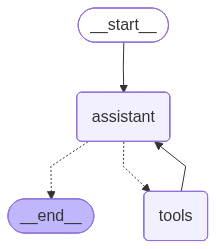

In [19]:
from IPython.display import Image, display

try:
    display(Image(part_1_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

#### Example Conversation

Now it's time to try out our mighty chatbot! Let's run it over the following list of dialog turns. If it hits a "RecursionLimit", that means the agent wasn't able to get an answer in the allocated number of steps. That's OK! We have more tricks up our sleeve in later sections of this tutorial.

In [22]:
import shutil
import uuid

# Let's create an example conversation a user might have with the assistant
# Please feel free comment some questions for debugging purposes
tutorial_questions = [
    "Hi there, what time is my flight?",
    "Am i allowed to update my flight to something sooner? I want to leave later today.",
    "Update my flight to sometime next week then",
    # "The next available option is great",
    # "what about lodging and transportation?",
    # "Yeah i think i'd like an affordable hotel for my week-long stay (7 days). And I'll want to rent a car.",
    # "OK could you place a reservation for your recommended hotel? It sounds nice.",
    # "yes go ahead and book anything that's moderate expense and has availability.",
    # "Now for a car, what are my options?",
    # "Awesome let's just get the cheapest option. Go ahead and book for 7 days",
    # "Cool so now what recommendations do you have on excursions?",
    # "Are they available while I'm there?",
    # "interesting - i like the museums, what options are there? ",
    # "OK great pick one and book it for my second day there.",
]

# Update with the backup file so we can restart from the original place in each section
db = update_dates(db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}


_printed = set()
for question in tutorial_questions:
    events = part_1_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)

================================ Human Message =================================

Hi there, what time is my flight?
================================== Ai Message ==================================
Tool Calls:
  fetch_user_flight_information (call_61a56eb0a0e140a190d190cb)
 Call ID: call_61a56eb0a0e140a190d190cb
  Args:
================================= Tool Message =================================
Name: fetch_user_flight_information

[{"ticket_no": "7240005432906569", "book_ref": "C46E9F", "flight_id": 19250, "flight_no": "LX0112", "departure_airport": "CDG", "arrival_airport": "BSL", "scheduled_departure": "2025-12-27 12:31:58.869548-04:00", "scheduled_arrival": "2025-12-27 14:01:58.869548-04:00", "seat_no": "18E", "fare_conditions": "Economy"}]
================================== Ai Message ==================================

Your flight **LX0112** (Swiss Airlines) from **Paris‑Charles de Gaulle (CDG)** to **Basel‑Mulhouse (BSL)** is scheduled to **depart at 12:31 PM on December 27, 

#### Part 1 Review

Our simple assistant is not bad! It was able to respond reasonably well for all the questions, quickly respond in-context, and successfully execute all our tasks. You can check out the trace at [Langsmith](https://smith.langchain.com/) to get a better sense of how the LLM is prompted throughout the interactions above.

If this were a simple Q&A bot, we'd probably be happy with the results above. Since our customer support bot is taking actions on behalf of the user, some of its behavior above is a bit concerning:

1. The assistant booked a car when we were focusing on lodging, then had to cancel and rebook later on: oops! The user should have final say before booking to avoid unwanted feeds.
2. The assistant struggled to search for recommendations. We could improve this by adding more verbose instructions and examples using the tool, but doing this for every tool can lead to a large prompt and overwhelmed agent.
3. The assistant had to do an explicit search just to get the user's relevant information. We can save a lot of time by fetching the user's relevant travel details immediately so the assistant can directly respond.

In the next section, we will address the first two of these issues.

## Part 2: Add Confirmation (2 points)

When an assistant takes actions on behalf of the user, the user should (almost) always have the final say on whether to follow through with the actions. Otherwise, any small mistake the assistant makes (or any prompt injection it succombs to) can cause real damage to the user.

In this section, we will use `interrupt_before` to pause the graph and return control to the user **before** executing any of the tools.

Your graph will look something like the following:

![](https://raw.githubusercontent.com/greedisneutral/NLP-course/refs/heads/2025/13.Agents/homework/img/part-2-diagram.png)

As before, start by defining the state:

#### State & Assistant

Our graph state and LLM calling is nearly identical to Part 1 except Exception:

- We've added a `user_info` field that will be eagerly populated by our graph
- We can use the state directly in the `Assistant` object rather than using the configurable params

In [23]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


# You could also use OpenAI or another model, though you will likely have
# to adapt the prompts
llm = ChatOpenAI(model="nvidia/nemotron-3-nano-30b-a3b:free")

# Feel free to experiment with the prompt if you feel so
assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for Swiss Airlines. "
            " Use the provided tools to search for flights, company policies, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

part_2_tools = [
    TavilySearchResults(max_results=1),
    fetch_user_flight_information,
    search_flights,
    lookup_policy,
    update_ticket_to_new_flight,
    cancel_ticket,
    search_car_rentals,
    book_car_rental,
    update_car_rental,
    cancel_car_rental,
    search_hotels,
    book_hotel,
    update_hotel,
    cancel_hotel,
    search_trip_recommendations,
    book_excursion,
    update_excursion,
    cancel_excursion,
]
part_2_assistant_runnable = assistant_prompt | llm.bind_tools(part_2_tools)

#### Define Graph

Now, create the graph. Make 2 changes from part 1 to address our previous concerns.

1. Add an interrupt before using a tool
2. Explicitly populate the user state within the first node so the assistant doesn't have to use a tool just to learn about the user.

The graph is already initialized for you. Now, you need to add nodes and edges to make it reflect our logic. You will find useful:
`START`, `END` nodes, `graph.add_node`, `graph.add_conditional_edges`, `graph.add_edge`.

In [25]:
def fetch_user_info_node(state: State, config: RunnableConfig):
    flights = fetch_user_flight_information.invoke({}, config=config)
    return {
        "user_info": flights,
        "messages": state["messages"],
    }


In [26]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


def user_info(state: State):
    return {"user_info": fetch_user_flight_information.invoke({})}

# GRAPH CONSTRUCTION HINT:
# Build a 3-node workflow with pre-population and human approval:
#
# 1. fetch_user_info node: Runs FIRST to load passenger data into state
#    - Connect START → fetch_user_info so it executes automatically
#    - This eliminates the assistant's need to call a tool just to learn about the user

builder.add_node(
    "fetch_user_info",
    RunnableLambda(fetch_user_info_node)
)
# 2. assistant node: The main LLM decision-maker
#    - Connect fetch_user_info → assistant so it runs with pre-loaded data
#    - The assistant can now immediately answer questions without initial tool calls

builder.add_node(
    "assistant",
    Assistant(part_2_assistant_runnable)
)

# 3. tools node: Where actions get executed
#    - Use add_conditional_edges from assistant to create a branching path
#    - The assistant decides whether to go to tools or end the conversation
#    - Connect tools → assistant to create a loop for multi-step reasoning

builder.add_node(
    "tools",
    create_tool_node_with_fallback(part_2_tools)
)

# FLOW: START → fetch_user_info → assistant → (if tools needed) → tools → assistant → ...
#
# KEY PATTERN: The interrupt_before=["tools"] parameter (in compile step) will pause
# execution before the tools node, giving users final approval on all actions.
#
# TO IMPLEMENT:
# - Create each node using builder.add_node(name, function_or_runnable)
# - Connect them with builder.add_edge(from_node, to_node) for fixed paths
# - Use builder.add_conditional_edges(from_node, routing_function) for dynamic paths
# - Reference Part 1's graph construction for the basic pattern
#
# YOU WILL FIND USEFUL:


builder.add_edge(START, "fetch_user_info")

builder.add_edge("fetch_user_info", "assistant")

builder.add_conditional_edges(
    "assistant",
    tools_condition,
)

builder.add_edge("tools", "assistant")


memory = InMemorySaver()
part_2_graph = builder.compile(
    checkpointer=memory,
    # The graph will always halt before executing the "tools" node.
    # The user can approve or reject (or even alter the request) before
    # the assistant continues
    interrupt_before=["tools"],
)

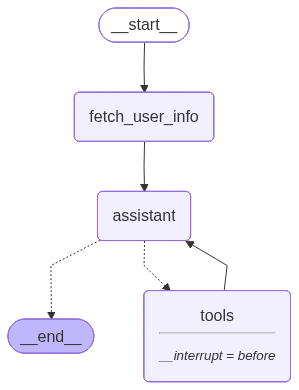

In [27]:
from IPython.display import Image, display

try:
    display(Image(part_2_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

#### Example Conversation

Now it's time to try out our newly revised chatbot! Let's run it over the following list of dialog turns.

In [30]:
import shutil
import uuid

# Update with the backup file so we can restart from the original place in each section
db = update_dates(db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

tutorial_questions = [
    "Hi there, what time is my flight?",
    "Am i allowed to update my flight to something sooner? I want to leave later today.",
    "Update my flight to sometime next week then",
    # "The next available option is great",
    # "what about lodging and transportation?",
    # "Yeah i think i'd like an affordable hotel for my week-long stay (7 days). And I'll want to rent a car.",
    # "OK could you place a reservation for your recommended hotel? It sounds nice.",
    # "yes go ahead and book anything that's moderate expense and has availability.",
    # "Now for a car, what are my options?",
    # "Awesome let's just get the cheapest option. Go ahead and book for 7 days",
    # "Cool so now what recommendations do you have on excursions?",
    # "Are they available while I'm there?",
    # "interesting - i like the museums, what options are there? ",
    # "OK great pick one and book it for my second day there.",
]

_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
for question in tutorial_questions:
    events = part_2_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = part_2_graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        try:
            user_input = input(
                "Do you approve of the above actions? Type 'y' to continue;"
                " otherwise, explain your requested changes.\n\n"
            )
        except:
            user_input = "y"
        if user_input.strip() == "y":
            # Just continue
            result = part_2_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = part_2_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = part_2_graph.get_state(config)

================================ Human Message =================================

Hi there, what time is my flight?
================================== Ai Message ==================================

Your flight **LX0112** from **Paris (CDG)** to **Basel (BSL)** is scheduled to **depart at 12:51:06** (local time, ‑04:00). It’s scheduled to **arrive at 14:21:06**. 

You’re about 4 minutes away from boarding! Let me know if you need anything else—like a check‑in link, seat details, or any other assistance.
================================ Human Message =================================

Am i allowed to update my flight to something sooner? I want to leave later today.
================================== Ai Message ==================================
Tool Calls:
  lookup_policy (call_c5e5b3ae3a904863a23258f4)
 Call ID: call_c5e5b3ae3a904863a23258f4
  Args:
    query: flight change policy
Do you approve of the above actions? Type 'y' to continue; otherwise, explain your requested changes.

y
D

#### Part 2 Review

Now our assistant was able to save a step to respond with our flight details. We also completely controlled which actions were performed. This all worked using LangGraph's `interrupts` and `checkpointers`. The interrupt pauses graph execution, its state safely persisted using your configured checkpointer. The user can then start it up at any time by running it with the right config.

See a LangSmith trace to get a better sense of how the graph is running. Note that you typically **resume** a flow by invoking the graph with `(None, config)`. The state is loaded from the checkpoint as if it never was interrupted.

This graph worked pretty well! We *didn't really* need to be involved in *EVERY* assistant action, though...

In the next section, we will reorganize our graph so that we can interrupt only on the "sensitive" actions that actually write to the database.

## Part 3: Conditional Interrupt (3 points)

In this section, we'll refine our interrupt strategy by categorizing tools as safe (read-only) or sensitive (data-modifying). We'll apply interrupts to the sensitive tools only, allowing the bot to handle simple queries autonomously.

This balances user control and conversational flow, but as we add more tools, our single graph may grow too complex for this "flat" structure. We'll address that in the next section.

Your graph for Part 3 will look something like the following diagram.

![](https://raw.githubusercontent.com/greedisneutral/NLP-course/refs/heads/2025/13.Agents/homework/img/part-3-diagram.png)

#### State

As always, start by defining the graph state. Our state and LLM calling **are identical to** part 2.


In [31]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


# You can update the LLMs, though you may need to update the prompts
# from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="nvidia/nemotron-3-nano-30b-a3b:free")

assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for Swiss Airlines. "
            " Use the provided tools to search for flights, company policies, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)


# "Read"-only tools (such as retrievers) don't need a user confirmation to use
part_3_safe_tools = [
    TavilySearchResults(max_results=1),
    fetch_user_flight_information,
    search_flights,
    lookup_policy,
    search_car_rentals,
    search_hotels,
    search_trip_recommendations,
]

# These tools all change the user's reservations.
# The user has the right to control what decisions are made
part_3_sensitive_tools = [
    update_ticket_to_new_flight,
    cancel_ticket,
    book_car_rental,
    update_car_rental,
    cancel_car_rental,
    book_hotel,
    update_hotel,
    cancel_hotel,
    book_excursion,
    update_excursion,
    cancel_excursion,
]
sensitive_tool_names = {t.name for t in part_3_sensitive_tools}
# Our LLM doesn't have to know which nodes it has to route to. In its 'mind', it's just invoking functions.
part_3_assistant_runnable = assistant_prompt | llm.bind_tools(
    part_3_safe_tools + part_3_sensitive_tools
)

#### Define Graph

Now, create the graph. Our graph is almost identical to part 2 **except** we split out the tools into 2 separate nodes. We only interrupt before the tools that are actually making changes to the user's bookings.

In [37]:
from typing import Literal

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


def user_info(state: State):
    return {"user_info": fetch_user_flight_information.invoke({})}

def route_tools(state: State):
    next_node = tools_condition(state)
    # If no tools are invoked, return to the user
    if next_node == END:
        return END
    ai_message = state["messages"][-1]
    # This assumes single tool calls. To handle parallel tool calling, you'd want to
    # use an ANY condition
    first_tool_call = ai_message.tool_calls[0]
    if first_tool_call["name"] in sensitive_tool_names:
        return "sensitive_tools"
    return "safe_tools"

# GRAPH CONSTRUCTION HINT:
# Build a 4-node workflow with intelligent routing based on tool risk:
#
# 1. fetch_user_info node: Same pre-population as Part 2
#    - START → fetch_user_info runs first to load user data

builder.add_node(
    "fetch_user_info",
    RunnableLambda(user_info)
)

# 2. assistant node: The LLM decides which tool category to use
#    - fetch_user_info → assistant ensures context is pre-loaded

builder.add_node(
    "assistant",
    Assistant(part_3_assistant_runnable)
)

# 3. Two tool nodes: Split by safety level
#    - safe_tools: Read-only operations (search_*, lookup_*, fetch_*)
#    - sensitive_tools: Write operations (book_*, update_*, cancel_*)
#    - This separation allows different handling for each category

builder.add_node(
    "safe_tools",
    ToolNode(part_3_safe_tools)
)

# 4. Dynamic routing: assistant chooses the path at runtime
#    - add_conditional_edges calls your route_tools(state) function
#    - route_tools must: examine the tool call, check its name, return the correct node name
#    - Possible returns: "safe_tools", "sensitive_tools", or END (if no tools needed)

builder.add_node(
    "sensitive_tools",
    ToolNode(part_3_sensitive_tools)
)

# FLOW: START → fetch_user_info → assistant → (route_tools decides) →
#       → safe_tools → assistant (automatic)
#       → sensitive_tools → assistant (requires approval)
#
# KEY PATTERN: The interrupt_before=["sensitive_tools"] parameter (in compile step)
# creates a smart approval system - searches happen instantly, bookings wait for permission.
#
# TO IMPLEMENT:
# - Create route_tools() that inspects state.messages[-1].tool_calls[0].name (already done, see above)
# - Compare tool names against your safe_tools and sensitive_tools lists
# - Return the appropriate string to direct the flow
# - Reference LangGraph's conditional edges documentation for routing patterns

builder.add_edge(START, "fetch_user_info")

builder.add_edge("fetch_user_info", "assistant")

builder.add_conditional_edges(
    "assistant",
    route_tools,
    {
        "safe_tools": "safe_tools",
        "sensitive_tools": "sensitive_tools",
        END: END,
    }
)

builder.add_edge("safe_tools", "assistant")
builder.add_edge("sensitive_tools", "assistant")

memory = InMemorySaver()
part_3_graph = builder.compile(
    checkpointer=memory,
    # NEW: The graph will always halt before executing the "tools" node.
    # The user can approve or reject (or even alter the request) before
    # the assistant continues
    interrupt_before=["sensitive_tools"],
)

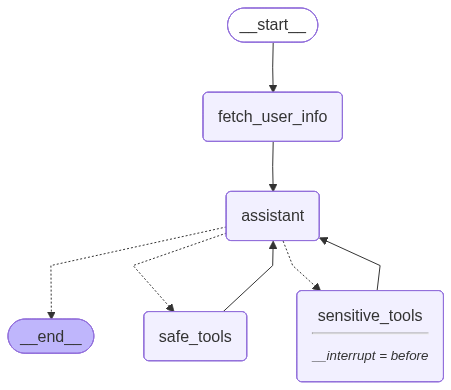

In [38]:
from IPython.display import Image, display

try:
    display(Image(part_3_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

#### Example Conversation

Now it's time to try out our newly revised chatbot! Let's run it over the following list of dialog turns. This time, we'll have many fewer confirmations.

In [39]:
import shutil
import uuid

# Update with the backup file so we can restart from the original place in each section
db = update_dates(db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

tutorial_questions = [
    "Hi there, what time is my flight?",
    "Am i allowed to update my flight to something sooner? I want to leave later today.",
    "Update my flight to sometime next week then",
    "The next available option is great",
    "what about lodging and transportation?",
    "Yeah i think i'd like an affordable hotel for my week-long stay (7 days). And I'll want to rent a car.",
    "OK could you place a reservation for your recommended hotel? It sounds nice.",
    "yes go ahead and book anything that's moderate expense and has availability.",
    "Now for a car, what are my options?",
    "Awesome let's just get the cheapest option. Go ahead and book for 7 days",
    "Cool so now what recommendations do you have on excursions?",
    "Are they available while I'm there?",
    "interesting - i like the museums, what options are there? ",
    "OK great pick one and book it for my second day there.",
]


_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
for question in tutorial_questions:
    events = part_3_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = part_3_graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        try:
            user_input = input(
                "Do you approve of the above actions? Type 'y' to continue;"
                " otherwise, explain your requested changed.\n\n"
            )
        except:
            user_input = "y"
        if user_input.strip() == "y":
            # Just continue
            result = part_3_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = part_3_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = part_3_graph.get_state(config)

================================ Human Message =================================

Hi there, what time is my flight?
================================== Ai Message ==================================

Your flight LX0112 is scheduled to **depart at 1:01 PM (13:01:42)** from Charles de Gaulle (CDG) and is expected to **arrive at 2:31 PM (14:31:42)** in Basel (BSL). 

Given the current time (12:57 PM), the flight will be boarding shortly. If you haven’t already, please make sure you’re at the gate and have your boarding pass ready. Safe travels!
================================ Human Message =================================

Am i allowed to update my flight to something sooner? I want to leave later today.
================================== Ai Message ==================================
Tool Calls:
  lookup_policy (call_5021a9f9278e4dee9ed41843)
 Call ID: call_5021a9f9278e4dee9ed41843
  Args:
    query: flight change policy
================================= Tool Message =====================

#### Part 3 Review

Much better! Our agent is now working well - check out a LangSmith trace of our latest run to inspect its work! You may be satisfied with this design. The code is contained, and it's behaving as desired.

One problem with this design is that we're putting a lot of pressure on a single prompt. If we want to add more tools, or if each tool gets more complicated (more filters, more business logic constraining behavior, etc), it's likely the tool usage and overall behavior of the bot will start to suffer.

In the next section, we show how you can take more control over different user experiences by routing to specialist agents or sub-graphs based on the user's intent.

## Part 4: Specialized Workflows (5 points)

In the previous sections, we saw how "wide" chat-bots, relying on a single prompt and LLM to handle various user intents, can get us far. However, it's difficult to create **predictably great** user experiences for known intents with this approach.

Alternatively, your graph can detect userintent and select the appropriate workflow or "skill" to satisfy the user's needs. Each workflow can focus on its domain, allowing for isolated improvements without degrading the overall assistant.

In this section, we'll split user experiences into separate sub-graphs, resulting in a structure like this:

![](https://raw.githubusercontent.com/greedisneutral/NLP-course/refs/heads/2025/13.Agents/homework/img/part-4-diagram.png)

In the diagram above, each square wraps an agentic, focused workflow. The primary assistant fields the user's initial queries, and the graph routes to the appropriate "expert" based on the query content.

#### State

We want to keep track of which sub-graph is in control at any given moment. While we _could_ do this through some arithmetic on the message list, it's easier to track as a dedicated **stack**.

Add a `dialog_state` list to the `State` below. Any time a `node` is run and returns a value for `dialog_state`, the `update_dialog_stack` function will be called to determine how to apply the update.

In [40]:
from typing import Annotated, Literal, Optional

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


def update_dialog_stack(left: list[str], right: Optional[str]) -> list[str]:
    """Push or pop the state."""
    if right is None:
        return left
    if right == "pop":
        return left[:-1]
    return left + [right]


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str
    dialog_state: Annotated[
        list[
            Literal[
                "assistant",
                "update_flight",
                "book_car_rental",
                "book_hotel",
                "book_excursion",
            ]
        ],
        update_dialog_stack,
    ]

#### Assistants

This time we will create an assistant **for every workflow**. That means:

1. Flight booking assistant
2. Hotel booking assistant
3. Car rental assistant
4. Excursion assistant
5. and finally, a "primary assistant" to route between these

If you're paying attention, you may recognize this as an example of the **supervisor** design pattern from our Multi-agent examples.

Below, define the `Runnable` objects to power each assistant.
Each `Runnable` has a prompt, LLM, and schemas for the tools scoped to that assistant.
Each *specialized* / delegated assistant additionally can call the `CompleteOrEscalate` tool to indicate that the control flow should be passed back to the primary assistant. This happens if it has successfully completed its work or if the user has changed their mind or needs assistance on something that beyond the scope of that particular workflow.

<div class="admonition note">
    <p class="admonition-title">Using Pydantic with LangChain</p>
    <p>
        This notebook uses Pydantic v2 <code>BaseModel</code>, which requires <code>langchain-core >= 0.3</code>. Using <code>langchain-core < 0.3</code> will result in errors due to mixing of Pydantic v1 and v2 <code>BaseModels</code>.
    </p>
</div>

In [41]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig

from pydantic import BaseModel, Field


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)

            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


class CompleteOrEscalate(BaseModel):
    """A tool to mark the current task as completed and/or to escalate control of the dialog to the main assistant,
    who can re-route the dialog based on the user's needs."""

    cancel: bool = True
    reason: str

    class Config:
        json_schema_extra = {
            "example": {
                "cancel": True,
                "reason": "User changed their mind about the current task.",
            },
            "example 2": {
                "cancel": True,
                "reason": "I have fully completed the task.",
            },
            "example 3": {
                "cancel": False,
                "reason": "I need to search the user's emails or calendar for more information.",
            },
        }


# Flight booking assistant
flight_booking_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling flight updates. "
            " The primary assistant delegates work to you whenever the user needs help updating their bookings. "
            "Confirm the updated flight details with the customer and inform them of any additional fees. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            " Remember that a booking isn't completed until after the relevant tool has successfully been used."
            "\n\nCurrent user flight information:\n<Flights>\n{user_info}\n</Flights>"
            "\nCurrent time: {time}."
            "\n\nIf the user needs help, and none of your tools are appropriate for it, then"
            ' "CompleteOrEscalate" the dialog to the host assistant. Do not waste the user\'s time. Do not make up invalid tools or functions.',
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

update_flight_safe_tools = [search_flights]
update_flight_sensitive_tools = [update_ticket_to_new_flight, cancel_ticket]
update_flight_tools = update_flight_safe_tools + update_flight_sensitive_tools
update_flight_runnable = flight_booking_prompt | llm.bind_tools(
    update_flight_tools + [CompleteOrEscalate]
)

# Hotel Booking Assistant
book_hotel_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling hotel bookings. "
            "The primary assistant delegates work to you whenever the user needs help booking a hotel. "
            "Search for available hotels based on the user's preferences and confirm the booking details with the customer. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            " Remember that a booking isn't completed until after the relevant tool has successfully been used."
            "\nCurrent time: {time}."
            '\n\nIf the user needs help, and none of your tools are appropriate for it, then "CompleteOrEscalate" the dialog to the host assistant.'
            " Do not waste the user's time. Do not make up invalid tools or functions."
            "\n\nSome examples for which you should CompleteOrEscalate:\n"
            " - 'what's the weather like this time of year?'\n"
            " - 'nevermind i think I'll book separately'\n"
            " - 'i need to figure out transportation while i'm there'\n"
            " - 'Oh wait i haven't booked my flight yet i'll do that first'\n"
            " - 'Hotel booking confirmed'",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

book_hotel_safe_tools = [search_hotels]
book_hotel_sensitive_tools = [book_hotel, update_hotel, cancel_hotel]
book_hotel_tools = book_hotel_safe_tools + book_hotel_sensitive_tools
book_hotel_runnable = book_hotel_prompt | llm.bind_tools(
    book_hotel_tools + [CompleteOrEscalate]
)

# Car Rental Assistant
book_car_rental_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling car rental bookings. "
            "The primary assistant delegates work to you whenever the user needs help booking a car rental. "
            "Search for available car rentals based on the user's preferences and confirm the booking details with the customer. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            " Remember that a booking isn't completed until after the relevant tool has successfully been used."
            "\nCurrent time: {time}."
            "\n\nIf the user needs help, and none of your tools are appropriate for it, then "
            '"CompleteOrEscalate" the dialog to the host assistant. Do not waste the user\'s time. Do not make up invalid tools or functions.'
            "\n\nSome examples for which you should CompleteOrEscalate:\n"
            " - 'what's the weather like this time of year?'\n"
            " - 'What flights are available?'\n"
            " - 'nevermind i think I'll book separately'\n"
            " - 'Oh wait i haven't booked my flight yet i'll do that first'\n"
            " - 'Car rental booking confirmed'",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

book_car_rental_safe_tools = [search_car_rentals]
book_car_rental_sensitive_tools = [
    book_car_rental,
    update_car_rental,
    cancel_car_rental,
]
book_car_rental_tools = book_car_rental_safe_tools + book_car_rental_sensitive_tools
book_car_rental_runnable = book_car_rental_prompt | llm.bind_tools(
    book_car_rental_tools + [CompleteOrEscalate]
)

# Excursion Assistant

book_excursion_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling trip recommendations. "
            "The primary assistant delegates work to you whenever the user needs help booking a recommended trip. "
            "Search for available trip recommendations based on the user's preferences and confirm the booking details with the customer. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " Remember that a booking isn't completed until after the relevant tool has successfully been used."
            "\nCurrent time: {time}."
            '\n\nIf the user needs help, and none of your tools are appropriate for it, then "CompleteOrEscalate" the dialog to the host assistant. Do not waste the user\'s time. Do not make up invalid tools or functions.'
            "\n\nSome examples for which you should CompleteOrEscalate:\n"
            " - 'nevermind i think I'll book separately'\n"
            " - 'i need to figure out transportation while i'm there'\n"
            " - 'Oh wait i haven't booked my flight yet i'll do that first'\n"
            " - 'Excursion booking confirmed!'",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

book_excursion_safe_tools = [search_trip_recommendations]
book_excursion_sensitive_tools = [book_excursion, update_excursion, cancel_excursion]
book_excursion_tools = book_excursion_safe_tools + book_excursion_sensitive_tools
book_excursion_runnable = book_excursion_prompt | llm.bind_tools(
    book_excursion_tools + [CompleteOrEscalate]
)


# Primary Assistant
class ToFlightBookingAssistant(BaseModel):
    """Transfers work to a specialized assistant to handle flight updates and cancellations."""

    request: str = Field(
        description="Any necessary followup questions the update flight assistant should clarify before proceeding."
    )


class ToBookCarRental(BaseModel):
    """Transfers work to a specialized assistant to handle car rental bookings."""

    location: str = Field(
        description="The location where the user wants to rent a car."
    )
    start_date: str = Field(description="The start date of the car rental.")
    end_date: str = Field(description="The end date of the car rental.")
    request: str = Field(
        description="Any additional information or requests from the user regarding the car rental."
    )

    class Config:
        json_schema_extra = {
            "example": {
                "location": "Basel",
                "start_date": "2023-07-01",
                "end_date": "2023-07-05",
                "request": "I need a compact car with automatic transmission.",
            }
        }


class ToHotelBookingAssistant(BaseModel):
    """Transfer work to a specialized assistant to handle hotel bookings."""

    location: str = Field(
        description="The location where the user wants to book a hotel."
    )
    checkin_date: str = Field(description="The check-in date for the hotel.")
    checkout_date: str = Field(description="The check-out date for the hotel.")
    request: str = Field(
        description="Any additional information or requests from the user regarding the hotel booking."
    )

    class Config:
        json_schema_extra = {
            "example": {
                "location": "Zurich",
                "checkin_date": "2023-08-15",
                "checkout_date": "2023-08-20",
                "request": "I prefer a hotel near the city center with a room that has a view.",
            }
        }


class ToBookExcursion(BaseModel):
    """Transfers work to a specialized assistant to handle trip recommendation and other excursion bookings."""

    location: str = Field(
        description="The location where the user wants to book a recommended trip."
    )
    request: str = Field(
        description="Any additional information or requests from the user regarding the trip recommendation."
    )

    class Config:
        json_schema_extra = {
            "example": {
                "location": "Lucerne",
                "request": "The user is interested in outdoor activities and scenic views.",
            }
        }


# The top-level assistant performs general Q&A and delegates specialized tasks to other assistants.
# The task delegation is a simple form of semantic routing / does simple intent detection
llm = ChatOpenAI(model="nvidia/nemotron-3-nano-30b-a3b:free")

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for Swiss Airlines. "
            "Your primary role is to search for flight information and company policies to answer customer queries. "
            "If a customer requests to update or cancel a flight, book a car rental, book a hotel, or get trip recommendations, "
            "delegate the task to the appropriate specialized assistant by invoking the corresponding tool. You are not able to make these types of changes yourself."
            " Only the specialized assistants are given permission to do this for the user."
            "The user is not aware of the different specialized assistants, so do not mention them; just quietly delegate through function calls. "
            "Provide detailed information to the customer, and always double-check the database before concluding that information is unavailable. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user flight information:\n<Flights>\n{user_info}\n</Flights>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)
primary_assistant_tools = [
    TavilySearchResults(max_results=1),
    search_flights,
    lookup_policy,
]
assistant_runnable = primary_assistant_prompt | llm.bind_tools(
    primary_assistant_tools
    + [
        ToFlightBookingAssistant,
        ToBookCarRental,
        ToHotelBookingAssistant,
        ToBookExcursion,
    ]
)

/tmp/ipython-input-2425444188.py:28: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  class CompleteOrEscalate(BaseModel):
/tmp/ipython-input-2425444188.py:188: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  class ToBookCarRental(BaseModel):
/tmp/ipython-input-2425444188.py:211: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  class ToHotelBookingAssistant(BaseModel):
/tmp/ipython-input-2425444188.py:234: PydanticDeprecatedSince20: Support for clas

#### Create Assistant

We're about ready to create the graph. In the previous section, we made the design decision to have a shared `messages` state between all the nodes. This is powerful in that each delegated assistant can see the entire user journey and have a shared context. This, however, means that weaker LLMs can easily get mixed up about there specific scope. To mark the "handoff" between the primary assistant and one of the delegated workflows (and complete the tool call from the router), we will add a `ToolMessage` to the state.


#### Utility

Create a function to make an "entry" node for each workflow, stating "the current assistant is `assistant_name`".

In [50]:
from typing import Callable

from langchain_core.messages import ToolMessage


def create_entry_node(assistant_name: str, new_dialog_state: str) -> Callable:
    def entry_node(state: State) -> dict:
        tool_call_id = state["messages"][-1].tool_calls[0]["id"]
        return {
            "messages": [
                ToolMessage(
                    content=f"The assistant is now the {assistant_name}. Reflect on the above conversation between the host assistant and the user."
                    f" The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are {assistant_name},"
                    " and the booking, update, other other action is not complete until after you have successfully invoked the appropriate tool."
                    " If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary host assistant take control."
                    " Do not mention who you are - just act as the proxy for the assistant.",
                    tool_call_id=tool_call_id,
                )
            ],
            "dialog_state": new_dialog_state,
        }

    return entry_node

#### Define Graph

Now it's time to start building our graph. As before, we'll start with a node to pre-populate the state with the user's current information.

In [79]:
from typing import Literal

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


def user_info(state: State):
    return {"user_info": fetch_user_flight_information.invoke({})}


builder.add_node("fetch_user_info", user_info)
builder.add_edge(START, "fetch_user_info")

Now we'll start adding our specialized workflows. Each mini-workflow looks very similar to our full graph in [Part 3](#part-3-conditional-interrupt), employing 5 nodes:

1. `enter_*`: use the `create_entry_node` utility you defined above to add a ToolMessage signaling that the new specialized assistant is at the helm
2. Assistant: the prompt + llm combo that takes in the current state and either uses a tool, asks a question of the user, or ends the workflow (return to the primary assistant)
3. `*_safe_tools`: "read-only" tools the assistant can use without user confirmation.
4. `*_sensitive_tools`: tools with "write" access that require user confirmation (and will be assigned an `interrupt_before` when we compile the graph)
5. `leave_skill`: _pop_ the `dialog_state` to signal that the *primary assistant* is back in control

Because of their similarities, we _could_ define a factory function to generate these. Since this is a tutorial, we'll define them each explicitly.

First, make the **flight booking assistant** dedicated to managing the user journey for updating and canceling flights.

##### Flight booking assistant (1 point)

In [80]:
def route_update_flight(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    safe_toolnames = [t.name for t in update_flight_safe_tools]
    if all(tc["name"] in safe_toolnames for tc in tool_calls):
        return "update_flight_safe_tools"
    return "update_flight_sensitive_tools"

# This node will be shared for exiting all specialized assistants
def pop_dialog_state(state: State) -> dict:
    """Pop the dialog stack and return to the main assistant.

    This lets the full graph explicitly track the dialog flow and delegate control
    to specific sub-graphs.
    """
    messages = []
    if state["messages"][-1].tool_calls:
        # Note: Doesn't currently handle the edge case where the llm performs parallel tool calls
        messages.append(
            ToolMessage(
                content="Resuming dialog with the host assistant. Please reflect on the past conversation and assist the user as needed.",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        )
    return {
        "dialog_state": "pop",
        "messages": messages,
    }

# FLIGHT UPDATE SUB-GRAPH CONSTRUCTION HINT:
# Build a self-contained specialist workflow that can be plugged into the main graph:
#
# 1. Entry node: Announces the handoff to user
#    - create_entry_node generates a ToolMessage like "Transferring to Flight Updates Assistant"
#    - This sets expectations and updates dialog_state to track the active specialist

builder.add_node(
    "enter_update_flight",
    create_entry_node("Flight Booking Assistant", "update_flight"),
)

# 2. Specialist assistant: Domain-focused LLM with limited tools
#    - update_flight_runnable should have a prompt that ONLY discusses flights
#    - It binds only flight-related tools + CompleteOrEscalate for returning
#    - This constraint prevents the assistant from booking hotels mid-flight-change

builder.add_node(
    "update_flight",
    Assistant(update_flight_runnable),
)

# 3. Tool nodes: Same safe/sensitive split pattern as Part 3
#    - Safe tools: search_flights, lookup_policy (execute automatically)
#    - Sensitive tools: update_ticket_to_new_flight, cancel_ticket (require approval)

builder.add_node(
    "update_flight_safe_tools",
    ToolNode(update_flight_safe_tools),
)

# 4. Dynamic routing: route_update_flight function with 4 possible paths
#    - "update_flight_safe_tools": For read-only flight searches
#    - "update_flight_sensitive_tools": For actual booking changes
#    - "leave_skill": When user says "never mind" or task is complete
#    - END: If the specialist decides the conversation is finished

builder.add_node(
    "update_flight_sensitive_tools",
    ToolNode(update_flight_sensitive_tools),
)

# 5. Exit node: Returns control to primary assistant
#    - pop_dialog_state removes "update_flight" from the dialog stack
#    - leave_skill → primary_assistant ensures seamless handoff back to main graph

builder.add_node("leave_skill", pop_dialog_state)

# FLOW: enter_update_flight → update_flight → (route_update_flight decides) →
#       → safe_tools → update_flight (loop)
#       → sensitive_tools → update_flight (loop, with approval)
#       → leave_skill → primary_assistant (return to main)
#
# KEY PATTERN: This sub-graph is COMPLETELY SELF-CONTAINED.
# The main graph doesn't need to know its internal structure - it just calls it and gets results back.
# This is how you build scalable multi-agent systems.
#
# TO IMPLEMENT:
# - Create update_flight_runnable with a flight-specific system prompt
# - Define route_update_flight that checks for CompleteOrEscalate tool calls
# - Ensure pop_dialog_state properly removes the current specialist from dialog_state
# - Reference Part 3's route_tools pattern but add the leave_skill/END options
builder.add_edge("enter_update_flight", "update_flight")

builder.add_conditional_edges(
    "update_flight",
    route_update_flight,
    {
        "update_flight_safe_tools": "update_flight_safe_tools",
        "update_flight_sensitive_tools": "update_flight_sensitive_tools",
        "leave_skill": "leave_skill",
        END: END,
    },
)

builder.add_edge("update_flight_safe_tools", "update_flight")
builder.add_edge("update_flight_sensitive_tools", "update_flight")


Next, create the **car rental assistant** graph to own all car rental needs.

##### Car rental assistant (1 point)

In [81]:
def route_book_car_rental(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    safe_toolnames = [t.name for t in book_car_rental_safe_tools]
    if all(tc["name"] in safe_toolnames for tc in tool_calls):
        return "book_car_rental_safe_tools"
    return "book_car_rental_sensitive_tools"

# CAR RENTAL SUB-GRAPH CONSTRUCTION HINT:
# Build a specialist workflow using the EXACT SAME pattern as the flight update sub-graph:
#
# 1. Entry node: Announces the handoff to Car Rental Assistant
#    - Creates a ToolMessage informing the user of the transition
#    - Updates dialog_state to "book_car_rental" to track the active specialist

builder.add_node(
    "enter_book_car_rental",
    create_entry_node("Car Rental Assistant", "book_car_rental"),
)

# 2. Specialist assistant: Domain-focused LLM for car rentals only
#    - book_car_rental_runnable should have a prompt restricting discussion to cars
#    - Binds only car rental tools: search_car_rentals, book_car_rental, update_car_rental, cancel_car_rental
#    - Includes CompleteOrEscalate to return to primary assistant when needed

builder.add_node(
    "book_car_rental",
    Assistant(book_car_rental_runnable),
)

# 3. Tool nodes: Safe/sensitive split for car operations
#    - Safe tools: search_car_rentals (read-only, executes automatically)
#    - Sensitive tools: book_car_rental, update_car_rental, cancel_car_rental (require approval)

builder.add_node(
    "book_car_rental_safe_tools",
    ToolNode(book_car_rental_safe_tools),
)

# 4. Dynamic routing: route_book_car_rental function with 4 exit paths
#    - "book_car_rental_safe_tools": For searching available cars
#    - "book_car_rental_sensitive_tools": For booking/changing/canceling reservations
#    - "leave_skill": User says "never mind" or task complete → returns to primary
#    - END: Conversation naturally concludes

builder.add_node(
    "book_car_rental_sensitive_tools",
    ToolNode(book_car_rental_sensitive_tools),
)

# FLOW: enter_book_car_rental → book_car_rental → (route_book_car_rental decides) →
#       → safe_tools → book_car_rental (loop)
#       → sensitive_tools → book_car_rental (loop, with approval)
#       → leave_skill → primary_assistant (return to main graph)
#
# KEY PATTERN: This is a TEMPLATE. Once you built the flight update sub-graph, you can
# copy-paste its structure and just change the names, tools, and prompts.
# This is how real software engineering works - establish a pattern, then replicate it.
#
# TO IMPLEMENT:
# - Copy the flight update sub-graph structure exactly
# - Replace "update_flight" with "book_car_rental" in all node names
# - Update the runnable to use car-specific tools and a car-focused prompt
# - The routing logic and edge structure remain identical
# - Reference Part 3's safe/sensitive tool pattern for the tool lists

builder.add_edge("enter_book_car_rental", "book_car_rental")

builder.add_conditional_edges(
    "book_car_rental",
    route_book_car_rental,
    {
        "book_car_rental_safe_tools": "book_car_rental_safe_tools",
        "book_car_rental_sensitive_tools": "book_car_rental_sensitive_tools",
        "leave_skill": "leave_skill",
        END: END,
    },
)

builder.add_edge("book_car_rental_safe_tools", "book_car_rental")
builder.add_edge("book_car_rental_sensitive_tools", "book_car_rental")

Then define the **hotel booking** workflow.

##### Hotel booking assistant (1 point)

In [82]:
def route_book_hotel(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    tool_names = [t.name for t in book_hotel_safe_tools]
    if all(tc["name"] in tool_names for tc in tool_calls):
        return "book_hotel_safe_tools"
    return "book_hotel_sensitive_tools"


# HOTEL BOOKING SUB-GRAPH CONSTRUCTION HINT:
# Build a specialist workflow using the ESTABLISHED TEMPLATE from flight and car rental:
#
# 1. Entry node: Announces the handoff to Hotel Booking Assistant
#    - Creates a ToolMessage informing the user they're now in hotel booking mode
#    - Updates dialog_state to "book_hotel" for tracking the active specialist

builder.add_node(
    "enter_book_hotel",
    create_entry_node("Hotel Booking Assistant", "book_hotel"),
)


# 2. Specialist assistant: Domain-focused LLM for hotels only
#    - book_hotel_runnable should have a prompt that ONLY discusses hotels
#    - Binds only hotel tools: search_hotels, book_hotel, update_hotel, cancel_hotel
#    - Includes CompleteOrEscalate to return to primary assistant when appropriate

builder.add_node(
    "book_hotel",
    Assistant(book_hotel_runnable),
)

# 3. Tool nodes: Safe/sensitive split for hotel operations
#    - Safe tools: search_hotels (read-only, executes automatically)
#    - Sensitive tools: book_hotel, update_hotel, cancel_hotel (require approval)

builder.add_node(
    "book_hotel_safe_tools",
    ToolNode(book_hotel_safe_tools),
)

# 4. Dynamic routing: route_book_hotel function with 4 exit paths
#    - "book_hotel_safe_tools": For searching available hotels
#    - "book_hotel_sensitive_tools": For booking/changing/canceling reservations
#    - "leave_skill": User says "never mind" or task complete → returns to primary
#    - END: Conversation naturally concludes

builder.add_node(
    "book_hotel_sensitive_tools",
    ToolNode(book_hotel_sensitive_tools),
)

# FLOW: enter_book_hotel → book_hotel → (route_book_hotel decides) →
#       → safe_tools → book_hotel (loop)
#       → sensitive_tools → book_hotel (loop, with approval)
#       → leave_skill → primary_assistant (return to main graph)
#
# KEY PATTERN: By now, you should see this is the EXACT SAME STRUCTURE repeated.
# The only differences are: (1) node names, (2) which tools are bound, (3) the specialist prompt.
# This is intentional - it's a proven pattern for building reliable, maintainable multi-agent systems.
# Once you understand one specialist, you can build unlimited others (excursions, billing, etc.).
#
# TO IMPLEMENT:
# - Replicate the flight/car pattern exactly - don't reinvent the structure
# - Update the runnable to use hotel-specific tools and a hotel-focused prompt
# - The routing logic follows the same template: check tool type, check for CompleteOrEscalate
# - Reference your working flight and car implementations - copy the pattern, change the content
builder.add_edge("enter_book_hotel", "book_hotel")

builder.add_conditional_edges(
    "book_hotel",
    route_book_hotel,
    {
        "book_hotel_safe_tools": "book_hotel_safe_tools",
        "book_hotel_sensitive_tools": "book_hotel_sensitive_tools",
        "leave_skill": "leave_skill",
        END: END,
    },
)

builder.add_edge("book_hotel_safe_tools", "book_hotel")
builder.add_edge("book_hotel_sensitive_tools", "book_hotel")


After that, define the **excursion assistant**.

##### Excursion assistant (1 point)

In [83]:
def route_book_excursion(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    tool_names = [t.name for t in book_excursion_safe_tools]
    if all(tc["name"] in tool_names for tc in tool_calls):
        return "book_excursion_safe_tools"
    return "book_excursion_sensitive_tools"

# EXCURSION BOOKING SUB-GRAPH CONSTRUCTION HINT:
# Build the FINAL specialist workflow using the MASTERED TEMPLATE:
#
# 1. Entry node: Announces the handoff to Trip Recommendation Assistant
#    - Creates a ToolMessage informing the user they're now in excursion booking mode
#    - Updates dialog_state to "book_excursion" for tracking the active specialist

builder.add_node(
    "enter_book_excursion",
    create_entry_node("Trip Recommendation Assistant", "book_excursion"),
)

# 2. Specialist assistant: Domain-focused LLM for excursions/trips only
#    - book_excursion_runnable should have a prompt that ONLY discusses excursions
#    - Binds only excursion tools: search_trip_recommendations, book_excursion, update_excursion, cancel_excursion
#    - Includes CompleteOrEscalate to return to primary assistant when appropriate

builder.add_node(
    "book_excursion",
    Assistant(book_excursion_runnable),
)

# 3. Tool nodes: Safe/sensitive split for excursion operations
#    - Safe tools: search_trip_recommendations (read-only, executes automatically)
#    - Sensitive tools: book_excursion, update_excursion, cancel_excursion (require approval)

builder.add_node(
    "book_excursion_safe_tools",
    ToolNode(book_excursion_safe_tools),
)

# 4. Dynamic routing: route_book_excursion function with 4 exit paths
#    - "book_excursion_safe_tools": For searching available excursions
#    - "book_excursion_sensitive_tools": For booking/changing/canceling activities
#    - "leave_skill": User says "never mind" or task complete → returns to primary
#    - END: Conversation naturally concludes

builder.add_node(
    "book_excursion_sensitive_tools",
    ToolNode(book_excursion_sensitive_tools),
)

# FLOW: enter_book_excursion → book_excursion → (route_book_excursion decides) →
#       → safe_tools → book_excursion (loop)
#       → sensitive_tools → book_excursion (loop, with approval)
#       → leave_skill → primary_assistant (return to main graph)
#
# KEY PATTERN: This is the FOURTH identical sub-graph structure. You have now mastered the pattern:
# - Entry announcement → Specialist LLM → Safe/Sensitive split → Conditional routing → Exit
# - The pattern scales infinitely: you could add 10 more specialists (billing, refunds, upgrades)
#   without changing the main graph logic at all.
# - This is how production multi-agent systems are built: reusable, composable components.
#
# TO IMPLEMENT:
# - Apply the flight/car/hotel pattern one final time - you should be able to do this from memory
# - Update the runnable to use excursion-specific tools and an excursion-focused prompt
# - The routing logic is identical: check tool type, check for CompleteOrEscalate, return path
# - Reference ANY of your previous three implementations - they all follow the same template
# - If this feels repetitive, GOOD! That means you've learned the pattern. Repetition is the point.
builder.add_edge("enter_book_excursion", "book_excursion")

builder.add_conditional_edges(
    "book_excursion",
    route_book_excursion,
    {
        "book_excursion_safe_tools": "book_excursion_safe_tools",
        "book_excursion_sensitive_tools": "book_excursion_sensitive_tools",
        "leave_skill": "leave_skill",
        END: END,
    },
)

builder.add_edge("book_excursion_safe_tools", "book_excursion")
builder.add_edge("book_excursion_sensitive_tools", "book_excursion")


Finally, create the **primary assistant**.

##### Primary assistant (1 point)

In [84]:
def route_primary_assistant(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls:
        if tool_calls[0]["name"] == ToFlightBookingAssistant.__name__:
            return "enter_update_flight"
        elif tool_calls[0]["name"] == ToBookCarRental.__name__:
            return "enter_book_car_rental"
        elif tool_calls[0]["name"] == ToHotelBookingAssistant.__name__:
            return "enter_book_hotel"
        elif tool_calls[0]["name"] == ToBookExcursion.__name__:
            return "enter_book_excursion"
        return "primary_assistant_tools"
    raise ValueError("Invalid route")

# Each delegated workflow can directly respond to the user
# When the user responds, we want to return to the currently active workflow
def route_to_workflow(
    state: State,
) -> Literal[
    "primary_assistant",
    "update_flight",
    "book_car_rental",
    "book_hotel",
    "book_excursion",
]:
    """If we are in a delegated state, route directly to the appropriate assistant."""
    dialog_state = state.get("dialog_state")
    if not dialog_state:
        return "primary_assistant"
    return dialog_state[-1]

# PRIMARY ASSISTANT & MAIN GRAPH INTEGRATION HINT:
# This is the "FRONT DESK" that orchestrates all specialized workflows:
#
# 1. Primary Assistant: The main receptionist that handles general queries
#    - assistant_runnable should have access to routing tools ONLY
#    - Routing tools: ToFlightBookingAssistant, ToBookCarRental, ToBookHotel, ToBookExcursion
#    - These tools tell the primary assistant when to delegate to a specialist
#    - The prompt should say: "If the user needs to book/modify something specific, use the appropriate routing tool"

builder.add_node(
    "primary_assistant",
    Assistant(assistant_runnable),
)

# 2. Primary Assistant Tools: Where routing decisions get executed
#    - primary_assistant_tools contains the actual routing tool implementations
#    - When the LLM calls ToFlightBookingAssistant, this node executes it

builder.add_node(
    "primary_assistant_tools",
    ToolNode(primary_assistant_tools),
)

# 3. Main Routing Logic: route_primary_assistant function
#    - Inspects the assistant's tool calls to determine where to route
#    - If user says "change my flight" → returns "enter_update_flight"
#    - If user says "book a hotel" → returns "enter_book_hotel"
#    - If user asks general question → returns "primary_assistant_tools" (for search/lookup)
#    - If conversation is done → returns END
#
# 4. Workflow Entry Point: route_to_workflow from fetch_user_info
#    - After pre-populating user info, decides which specialist to start with
#    - Example: If user has a flight soon, might route directly to flight assistant
#    - This creates a proactive agent that anticipates user needs


# FLOW: fetch_user_info → (route_to_workflow decides) →
#       → primary_assistant → (route_primary_assistant decides) →
#       → [specialist entry node] → [specialist sub-graph] → leave_skill → primary_assistant
#
# KEY PATTERN: This is a HIERARCHICAL MULTI-AGENT SYSTEM:
# - Primary assistant = Receptionist (knows who to call, not every detail)
# - Specialists = Department experts (deep knowledge, focused tools)
# - Dialog state = Call transfer log (tracks who user is talking to)
# - This scales infinitely: add new specialists without changing primary assistant logic
#
# TO IMPLEMENT:
# - Define routing tools as Pydantic models with clear descriptions
# - route_primary_assistant must inspect tool calls and return the exact node name string
# - route_to_workflow should analyze user_info and decide the most relevant starting point
# - Reference LangGraph's add_graph() documentation to connect sub-graphs to main graph
builder.add_edge("leave_skill", "primary_assistant")

builder.add_conditional_edges(
    "fetch_user_info",
    route_to_workflow,
)
builder.add_conditional_edges(
    "primary_assistant",
    route_primary_assistant,
    {
        "enter_update_flight": "enter_update_flight",
        "enter_book_car_rental": "enter_book_car_rental",
        "enter_book_hotel": "enter_book_hotel",
        "enter_book_excursion": "enter_book_excursion",
        "primary_assistant_tools": "primary_assistant_tools",
        END: END,
    },
)
builder.add_edge("primary_assistant_tools", "primary_assistant")
part_4_graph = builder.compile(
    checkpointer=InMemorySaver(),
    interrupt_before=[
        "update_flight_sensitive_tools",
        "book_car_rental_sensitive_tools",
        "book_hotel_sensitive_tools",
        "book_excursion_sensitive_tools",
    ],
)


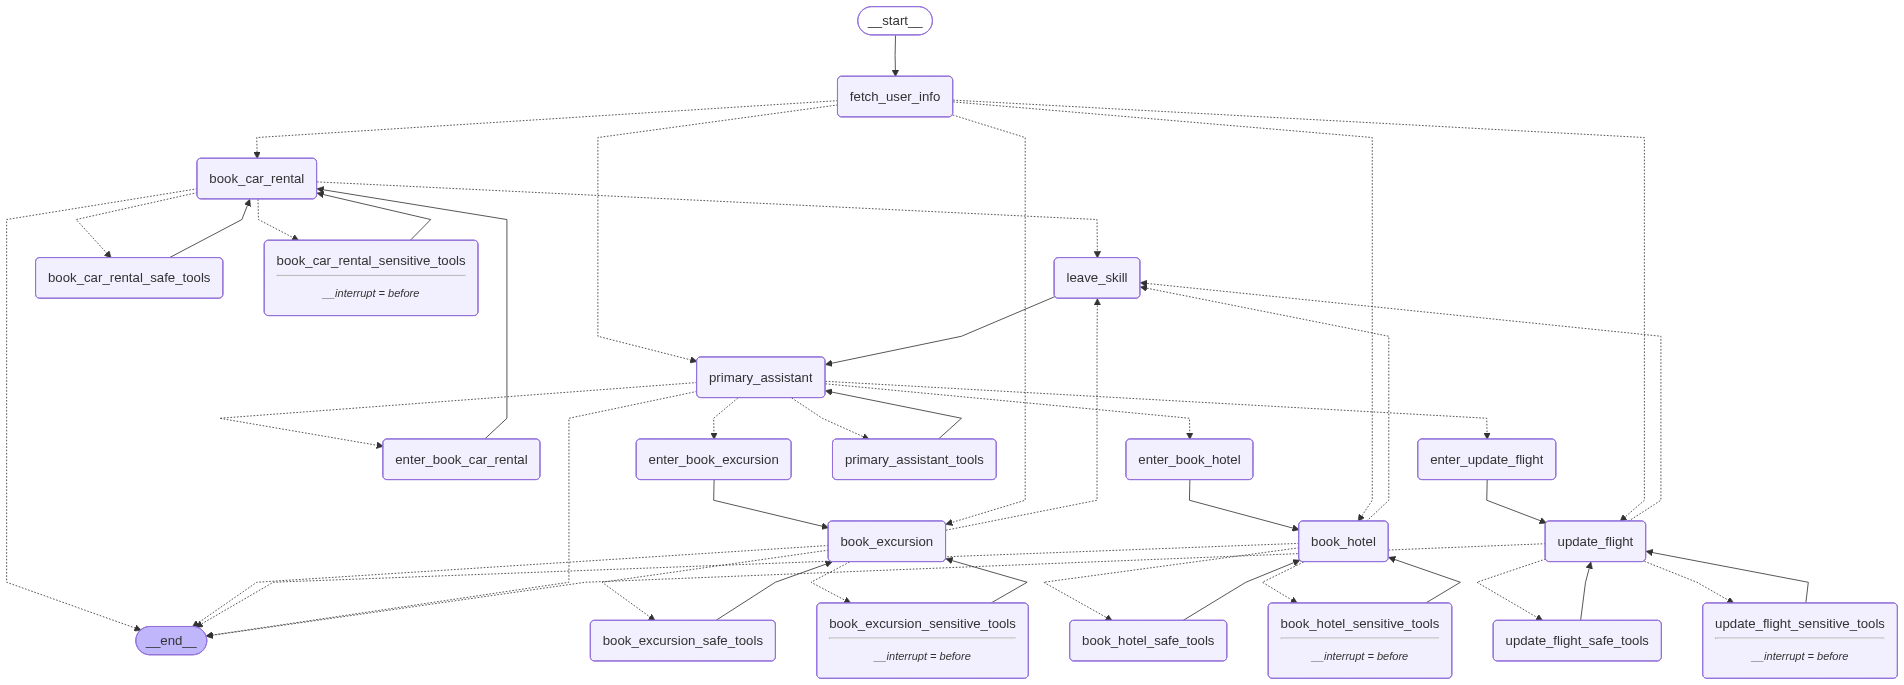

In [85]:
from IPython.display import Image, display

try:
    display(Image(part_4_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

#### Conversation

That was a lot! Let's run it over the following list of dialog turns. This time, we'll have many fewer confirmations.

In [86]:
import shutil
import uuid

# Update with the backup file so we can restart from the original place in each section
db = update_dates(db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

tutorial_questions = [
    "Hi there, what time is my flight?",
    "Am i allowed to update my flight to something sooner? I want to leave later today.",
    "Update my flight to sometime next week then",
    "The next available option is great",
    "what about lodging and transportation?",
    "Yeah i think i'd like an affordable hotel for my week-long stay (7 days). And I'll want to rent a car.",
    "OK could you place a reservation for your recommended hotel? It sounds nice.",
    "yes go ahead and book anything that's moderate expense and has availability.",
    "Now for a car, what are my options?",
    "Awesome let's just get the cheapest option. Go ahead and book for 7 days",
    "Cool so now what recommendations do you have on excursions?",
    "Are they available while I'm there?",
    "interesting - i like the museums, what options are there? ",
    "OK great pick one and book it for my second day there.",
]

_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
for question in tutorial_questions:
    events = part_4_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = part_4_graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        try:
            user_input = input(
                "Do you approve of the above actions? Type 'y' to continue;"
                " otherwise, explain your requested changed.\n\n"
            )
        except:
            user_input = "y"
        if user_input.strip() == "y":
            # Just continue
            result = part_4_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = part_4_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = part_4_graph.get_state(config)

================================ Human Message =================================

Hi there, what time is my flight?
================================== Ai Message ==================================

Your flight (flight LX0112) is scheduled to **depart at 14:17:38** and **arrive at 15:47:38** on **27 December 2025**.  
- Departure airport: Paris Charles de Gaulle (CDG)  
- Arrival airport: Basel (BSL)  
- Seat: 18E (Economy)  

So you have just a few minutes before boarding. Let me know if you need anything else—e.g., gate information, baggage allowances, or any other assistance.
================================ Human Message =================================

Am i allowed to update my flight to something sooner? I want to leave later today.
================================== Ai Message ==================================
Tool Calls:
  lookup_policy (call_5ed13952d1ea470984abb3ac)
 Call ID: call_5ed13952d1ea470984abb3ac
  Args:
    query: flight update policy
=============================

#### Conclusion:

You've now developed a customer support bot that handles diverse tasks using focused workflows.
More importantly, you've learned to use some of LangGraph's core features to design and refactor an application based on your product needs.

#### The world beyond a homework

The above examples are by no means optimized for your unique needs - LLMs make mistakes, and each flow can be made more reliable through better prompts and experimentation. Once you've created your initial support bot, the next step would be to start [adding evaluations](https://docs.smith.langchain.com/evaluation) so you can confidently improve your system. Check out those docs and lecture material to learn more!

You can also organize tools using Model-Context Protocol [MCP](https://docs.langchain.com/oss/python/langchain/mcp) to better abstract away tool management.

As far as the pipleine is concerned, you can add a verification step with another model to minimize a stochastic effect the model has on the output. Also, adding guardrails [Guardrails](https://docs.langchain.com/oss/python/langchain/guardrails) to prevent potential hacks would be a good idea if you intend to make your solution public.